# Retrieve awards for a director (or actor)

In [6]:
import numpy as np
import pandas as pd
import time
from bs4 import BeautifulSoup
import json
import requests
import random


In [22]:
import numpy as np
import pandas as pd


df_award = pd.read_csv("spielberg_awards.csv", sep=",", engine='python')

In [7]:
director_name="steven spielberg"

In [11]:
#let's get tmdb_id from director_name
director = director_name.replace(" ","%20")
query_for_tmdbID = "https://api.themoviedb.org/3/search/person?api_key=04fe0efd7c6e8c505128686c70ae5825&query="+director
results = requests.get(query_for_tmdbID)
dic_results = json.loads(results.text)
try:
    tmdbID = dic_results["results"][0]["id"]

    #let's get imdb_id from tmdb_id
    query_for_imdbID = "https://api.themoviedb.org/3/person/"+str(tmdbID)+"/external_ids?api_key=04fe0efd7c6e8c505128686c70ae5825"
    results = requests.get(query_for_imdbID)
    dic_results = json.loads(results.text)
    imdbID = dic_results["imdb_id"]
    print(director_name+" : imdbID = "+imdbID)
except:
    print("director not found")


steven%20spielberg:imdbID = nm0000229


In [12]:
#query IMDB
url = "http://www.imdb.com/name/"+imdbID+"/awards"
r  = requests.get(url)
data = r.text
soup = BeautifulSoup(data,"lxml")

df_award=pd.DataFrame(columns=['name','ceremony','year','category','outcome'])

# Find all of the text between paragraph tags and strip out the html
itag=0
collection_tag =soup.find_all()
while itag<len(collection_tag):
    tag=collection_tag[itag]
    tagtext = tag.text.lower()
    #We stop at each award_ceremony, to get all award_years
    if tag.name=="h3" and director_name.lower() not in tagtext and "imdb" not in tagtext and "user" not in tagtext :
        ceremony = tag.text
        #let's go through each year and stop at next H3 tag
        allow_next=True
        while allow_next:
            itag+=1
            tag=collection_tag[itag]
            #let's go through all tags and find outcome(s)/category(s) for each year
            stay_on_tag=True
            for key,value in tag.attrs.items():
                if not stay_on_tag:
                    break
                if key=="class":
                    if value[0]=="award_year":
                        year=int(collection_tag[itag].text)
                        stay_on_tag=False
                    elif value[0]=="award_outcome":                        
                        outcome=collection_tag[itag+1].text
                    elif value[0]=="award_category":
                        category=collection_tag[itag].text
                        #we should have a complete row : name / ceremony / category / outcome
                        new_row=len(df_award)+1
                        df_award.loc[new_row,["name"]]=director_name
                        df_award.loc[new_row,["ceremony"]]=ceremony
                        df_award.loc[new_row,["year"]]=year
                        df_award.loc[new_row,["category"]]=category
                        df_award.loc[new_row,["outcome"]]=outcome
                        
            #if you bump on a next ceremony come back one step before and analyse it
            if tag.name=="h3":
                allow_next=False
                itag-=1
    itag+=1
df_award[-5:]


,name,ceremony,year,category,outcome
327,steven spielberg,WorldFest Houston,1972,Gold Remi Award,Won
328,steven spielberg,"Writers Guild of America, USA",1978,WGA Award (Screen),Nominated
329,steven spielberg,"Writers Guild of America, USA",1975,WGA Award (Screen),Nominated
330,steven spielberg,Yoga Awards,1994,Yoga Award,Won
331,steven spielberg,Young Artist Awards,1994,Jackie Coogan Award,Won


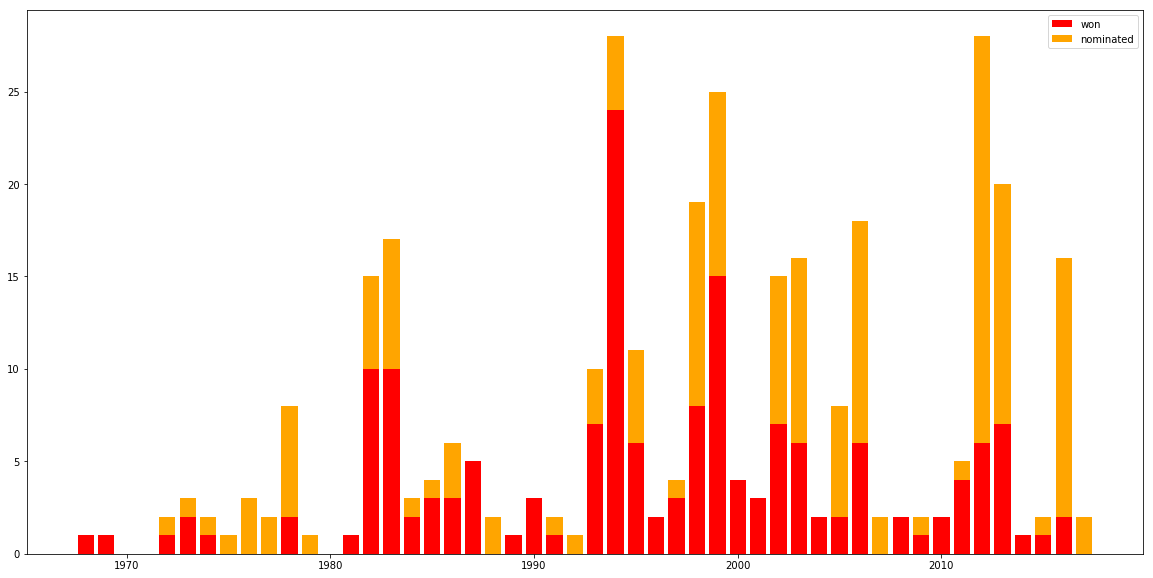

In [15]:
#count won & nominated
df_award["simplified_outcome"]="Nominated"
df_award.loc[df_award["outcome"]=="Won","simplified_outcome"]="Won"
group = df_award.groupby(by=["year","simplified_outcome"]).count()

#chart won & nominated
min_year=df_award["year"].min()
max_year=df_award["year"].max()+1

won_serie=pd.Series(index=range(min_year,max_year))
nominated_serie=pd.Series(index=range(min_year,max_year))

for i in range(min_year,max_year):
    won_serie[i]=0
    nominated_serie[i]=0

for i in range(len(group.index)):
    if group.index[i][1]=="Won":
        won_serie[group.index[i][0]]=group.iloc[i]["name"]
    if group.index[i][1]=="Nominated":
        nominated_serie[group.index[i][0]]=group.iloc[i]["name"]
        
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(range(min_year,max_year), won_serie, color = 'red')
plt.bar(range(min_year,max_year), nominated_serie, color = 'orange', bottom = won_serie)
plt.legend(('won','nominated'))
plt.show()